<a href="https://colab.research.google.com/github/marcinwolter/MachineLearning2020/blob/main/dcgan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Writing a training loop from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/01<br>
**Last modified:** 2020/04/15<br>
**Description:** Complete guide to writing low-level training & evaluation loops.

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch?hl=en 

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

import matplotlib.pyplot as plt

## Introduction

Keras provides default training and evaluation loops, `fit()` and `evaluate()`.
Their usage is covered in the guide
[Training & evaluation with the built-in methods](/guides/training_with_built_in_methods/).

If you want to customize the learning algorithm of your model while still leveraging
the convenience of `fit()`
(for instance, to train a GAN using `fit()`), you can subclass the `Model` class and
implement your own `train_step()` method, which
is called repeatedly during `fit()`. This is covered in the guide
[Customizing what happens in `fit()`](/guides/customizing_what_happens_in_fit/).

Now, if you want very low-level control over training & evaluation, you should write
your own training & evaluation loops from scratch. This is what this guide is about.

## End-to-end example: a GAN training loop from scratch

You may be familiar with Generative Adversarial Networks (GANs). GANs can generate new
images that look almost real, by learning the latent distribution of a training
dataset of images (the "latent space" of the images).

A GAN is made of two parts: a "generator" model that maps points in the latent
space to points in image space, a "discriminator" model, a classifier
that can tell the difference between real images (from the training dataset)
and fake images (the output of the generator network).

A GAN training loop looks like this:

1) Train the discriminator.
- Sample a batch of random points in the latent space.
- Turn the points into fake images via the "generator" model.
- Get a batch of real images and combine them with the generated images.
- Train the "discriminator" model to classify generated vs. real images.

2) Train the generator.
- Sample random points in the latent space.
- Turn the points into fake images via the "generator" network.
- Get a batch of real images and combine them with the generated images.
- Train the "generator" model to "fool" the discriminator and classify the fake images
as real.

For a much more detailed overview of how GANs works, see
[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

Let's implement this training loop. First, create the discriminator meant to classify
fake vs real digits:

In [2]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
_________________________________________________

Then let's create a generator network,
that turns latent vectors into outputs of shape `(28, 28, 1)` (representing
MNIST digits):

In [3]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

## Speeding-up your training step with `tf.function`

The default runtime in TensorFlow 2.0 is
[eager execution](https://www.tensorflow.org/guide/eager). As such, our training loop
above executes eagerly.

This is great for debugging, but graph compilation has a definite performance
advantage. Describing your computation as a static graph enables the framework
to apply global performance optimizations. This is impossible when
the framework is constrained to greedly execute one operation after another,
with no knowledge of what comes next.

You can compile into a static graph any function that takes tensors as input.
Just add a `@tf.function` decorator on it, like this:

Here's the key bit: the training loop. As you can see it is quite straightforward. The
training step function only takes 17 lines.

In [4]:
# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0004)

# Instantiate a loss function.
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)


@tf.function
def train_step(real_images):
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Decode them to fake images
    generated_images = generator(random_latent_vectors)
    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(labels.shape)

    # Train the discriminator
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return d_loss, g_loss, generated_images


Let's train our GAN, by repeatedly calling `train_step` on batches of images.

Since our discriminator and generator are convnets, you're going to want to
run this code on a GPU.

11493376/11490434 [==============================] - 0s 0us/step

Start epoch 0
Epoch =  0
discriminator loss at epoch 0: 0.56
adversarial loss at epoch 0: 1.61


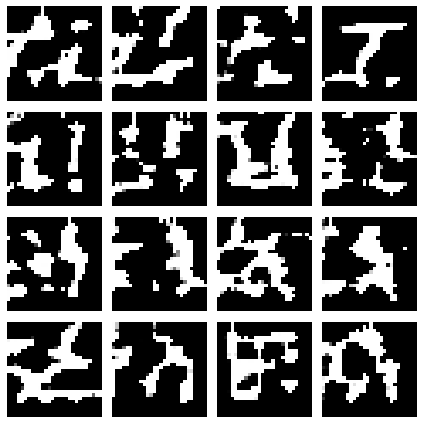


Start epoch 1
Epoch =  1
discriminator loss at epoch 1: 0.14
adversarial loss at epoch 1: 3.11


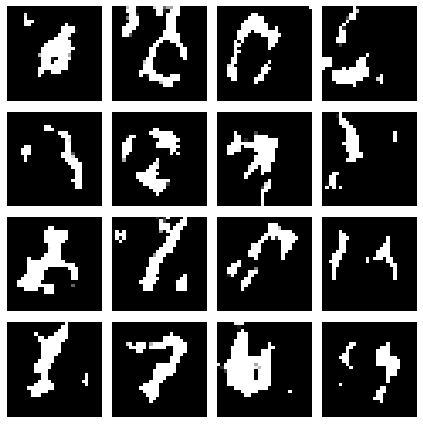


Start epoch 2
Epoch =  2
discriminator loss at epoch 2: 0.76
adversarial loss at epoch 2: 1.04


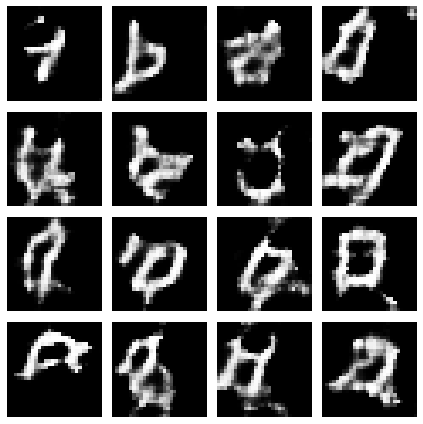


Start epoch 3
Epoch =  3
discriminator loss at epoch 3: 0.65
adversarial loss at epoch 3: 0.96


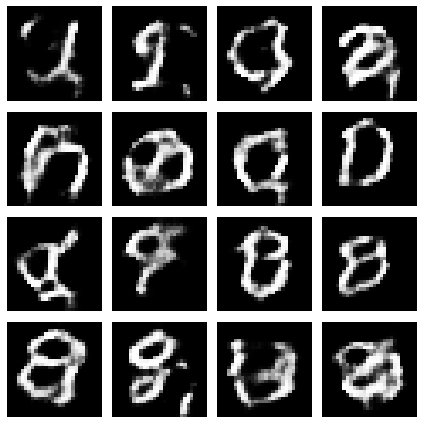


Start epoch 4
Epoch =  4
discriminator loss at epoch 4: 0.68
adversarial loss at epoch 4: 0.99


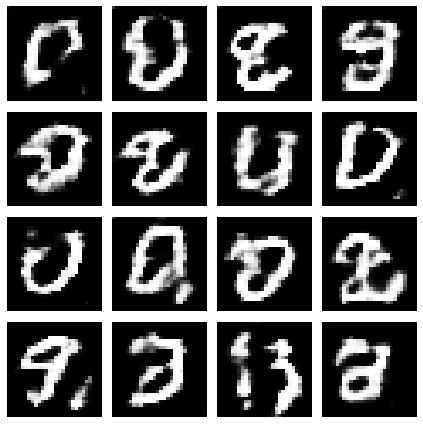


Start epoch 5
Epoch =  5
discriminator loss at epoch 5: 0.60
adversarial loss at epoch 5: 0.91


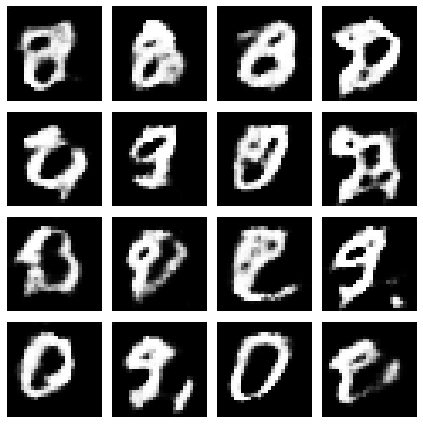


Start epoch 6
Epoch =  6
discriminator loss at epoch 6: 0.62
adversarial loss at epoch 6: 1.07


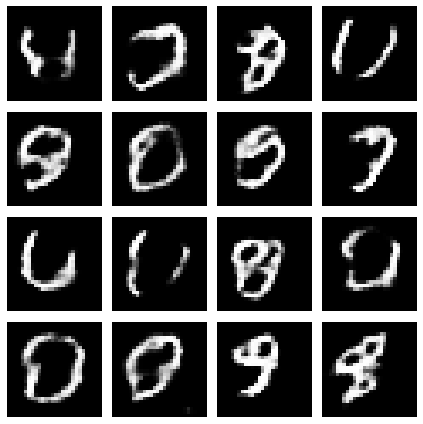


Start epoch 7
Epoch =  7
discriminator loss at epoch 7: 0.58
adversarial loss at epoch 7: 1.08


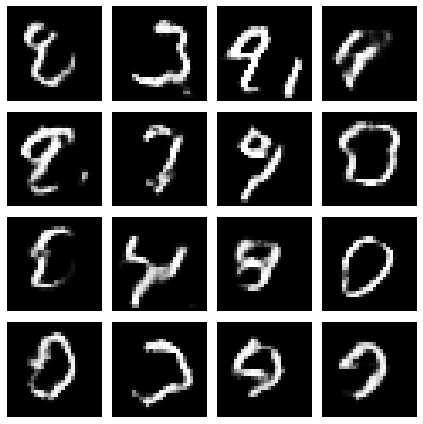


Start epoch 8
Epoch =  8
discriminator loss at epoch 8: 0.59
adversarial loss at epoch 8: 1.00


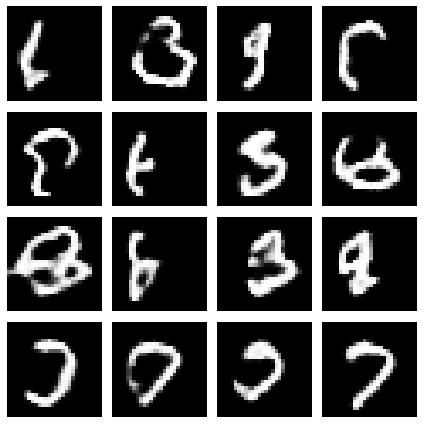


Start epoch 9
Epoch =  9
discriminator loss at epoch 9: 0.54
adversarial loss at epoch 9: 1.14


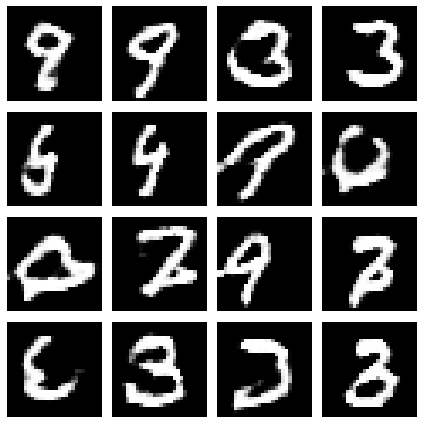


Start epoch 10
Epoch =  10
discriminator loss at epoch 10: 0.56
adversarial loss at epoch 10: 0.98


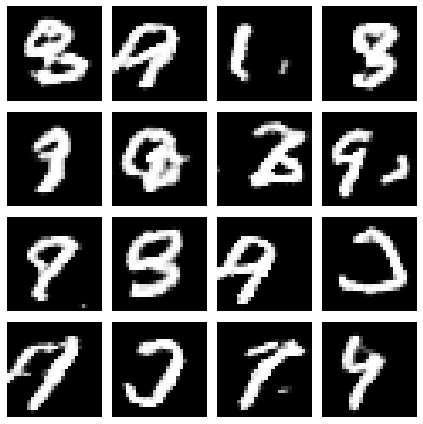


Start epoch 11
Epoch =  11
discriminator loss at epoch 11: 0.68
adversarial loss at epoch 11: 0.87


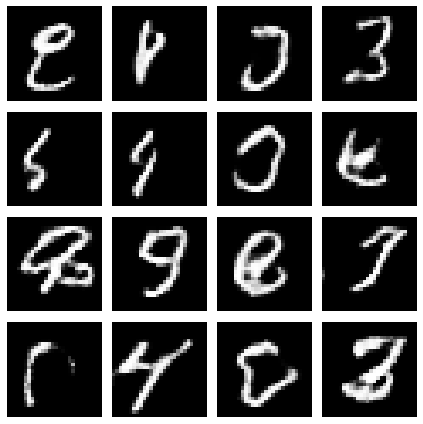


Start epoch 12
Epoch =  12
discriminator loss at epoch 12: 0.51
adversarial loss at epoch 12: 1.19


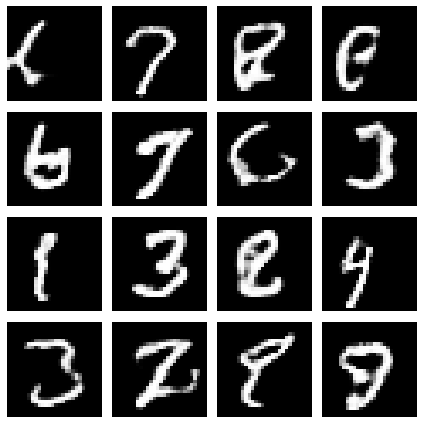


Start epoch 13
Epoch =  13
discriminator loss at epoch 13: 0.55
adversarial loss at epoch 13: 1.08


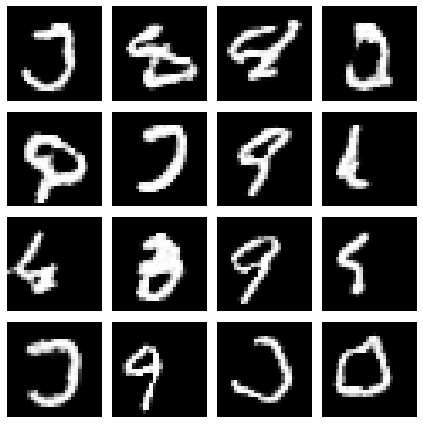


Start epoch 14
Epoch =  14
discriminator loss at epoch 14: 0.61
adversarial loss at epoch 14: 1.11


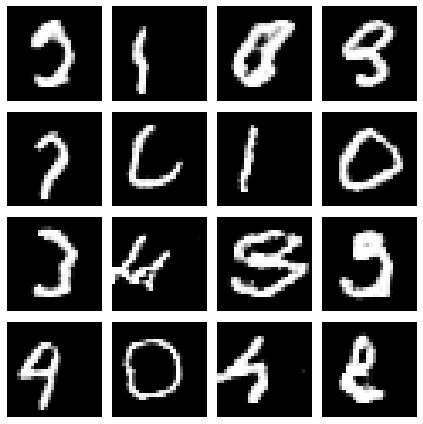


Start epoch 15
Epoch =  15
discriminator loss at epoch 15: 0.60
adversarial loss at epoch 15: 1.16


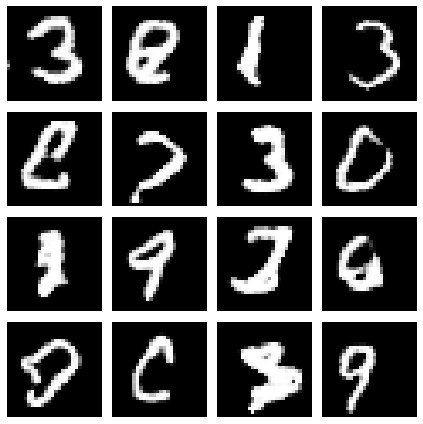


Start epoch 16
Epoch =  16
discriminator loss at epoch 16: 0.54
adversarial loss at epoch 16: 1.38


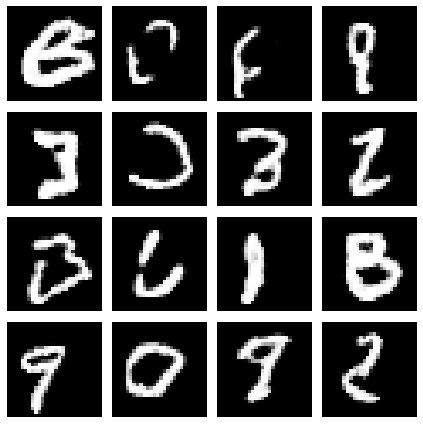


Start epoch 17
Epoch =  17
discriminator loss at epoch 17: 0.55
adversarial loss at epoch 17: 1.12


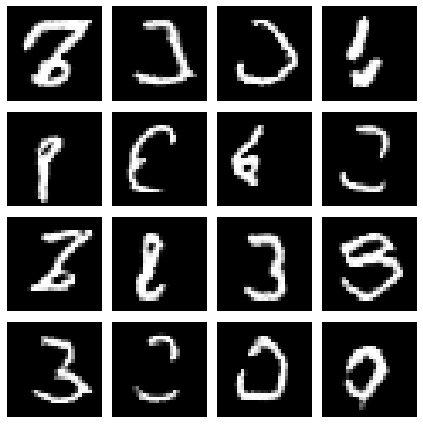


Start epoch 18
Epoch =  18
discriminator loss at epoch 18: 0.62
adversarial loss at epoch 18: 1.20


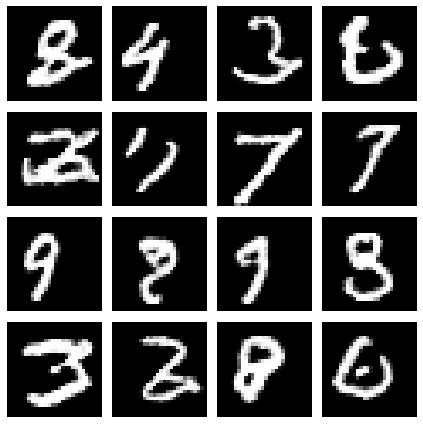


Start epoch 19
Epoch =  19
discriminator loss at epoch 19: 0.62
adversarial loss at epoch 19: 1.15


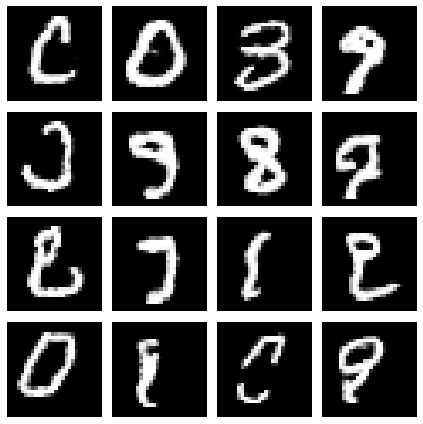


Start epoch 20
Epoch =  20
discriminator loss at epoch 20: 0.59
adversarial loss at epoch 20: 1.27


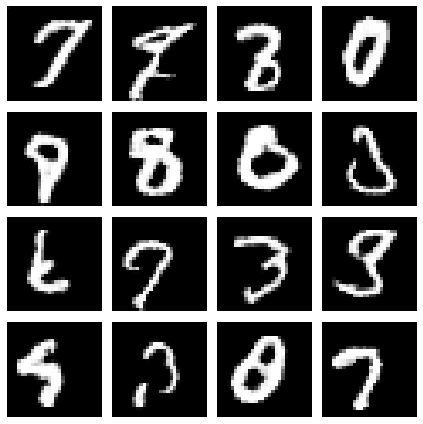


Start epoch 21
Epoch =  21
discriminator loss at epoch 21: 0.54
adversarial loss at epoch 21: 1.18


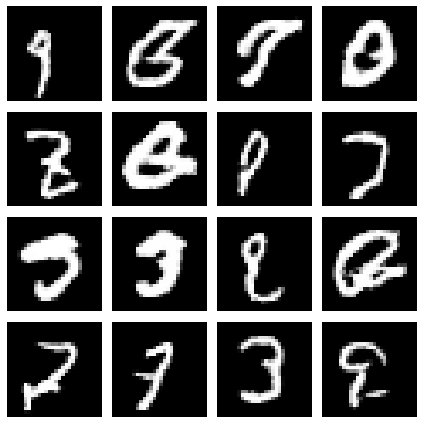


Start epoch 22
Epoch =  22
discriminator loss at epoch 22: 0.59
adversarial loss at epoch 22: 1.09


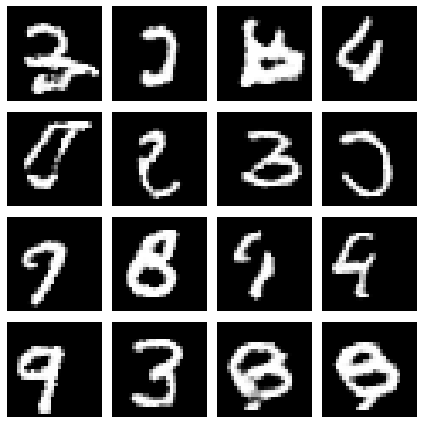


Start epoch 23
Epoch =  23
discriminator loss at epoch 23: 0.60
adversarial loss at epoch 23: 1.02


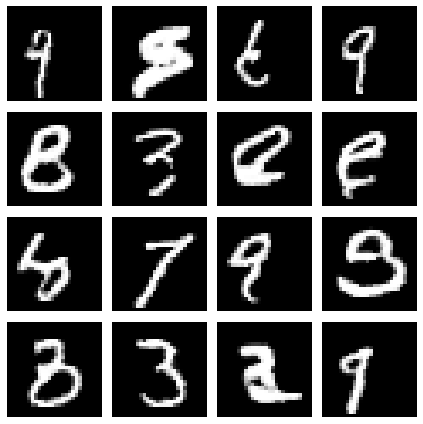


Start epoch 24
Epoch =  24
discriminator loss at epoch 24: 0.58
adversarial loss at epoch 24: 1.22


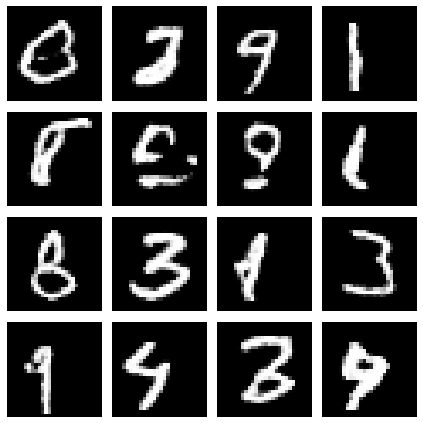


Start epoch 25
Epoch =  25
discriminator loss at epoch 25: 0.59
adversarial loss at epoch 25: 1.23


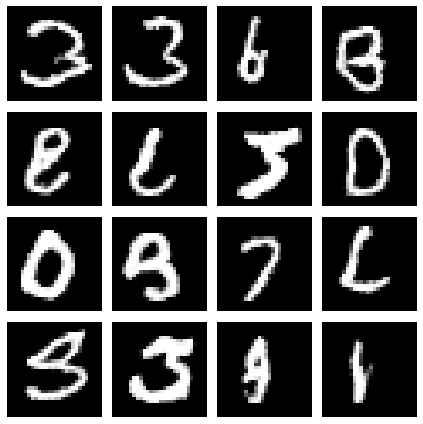


Start epoch 26
Epoch =  26
discriminator loss at epoch 26: 0.59
adversarial loss at epoch 26: 1.05


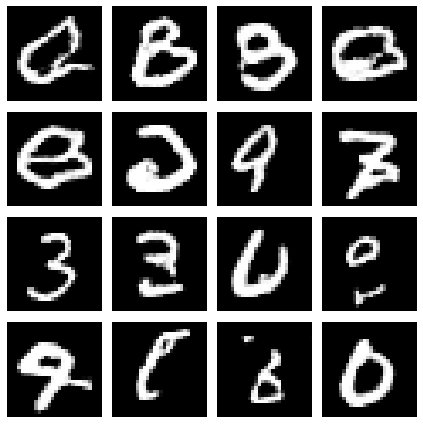


Start epoch 27
Epoch =  27
discriminator loss at epoch 27: 0.59
adversarial loss at epoch 27: 1.25


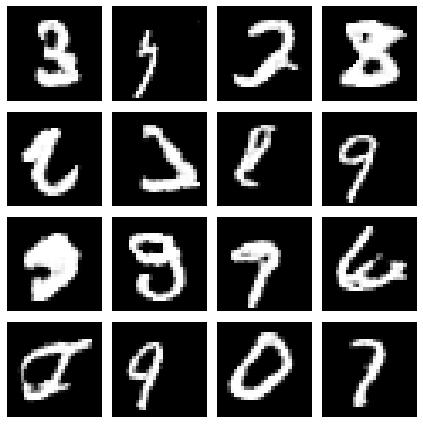


Start epoch 28
Epoch =  28
discriminator loss at epoch 28: 0.63
adversarial loss at epoch 28: 1.24


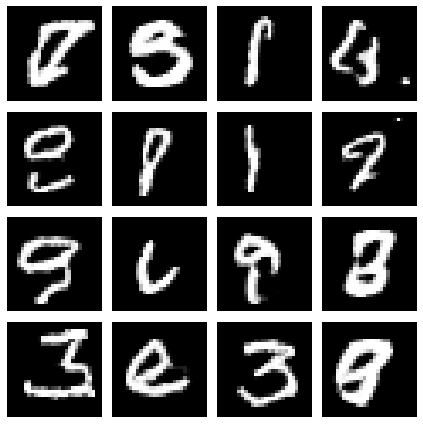


Start epoch 29
Epoch =  29
discriminator loss at epoch 29: 0.64
adversarial loss at epoch 29: 1.09


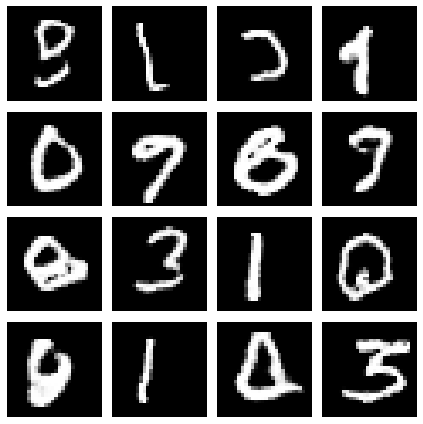

In [5]:
import os

# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
buffer_size=4096
dataset = dataset.shuffle(buffer_size=buffer_size).batch(batch_size)

epochs = 100  # In practice you need at least 20 epochs to generate nice digits.
save_dir = "./"

for epoch in range(epochs):
    print("\nStart epoch", epoch)

    for step, real_images in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(real_images)

    # Logging.
    #if step % (buffer_size-1) == 0:
    # Print metrics
    print("Epoch = ",epoch)
    print("discriminator loss at epoch %d: %.2f" % (epoch, d_loss))
    print("adversarial loss at epoch %d: %.2f" % (epoch, g_loss))

    # Save one generated image
    #img = tf.keras.preprocessing.image.array_to_img(
    #    generated_images[0] * 255.0, scale=False
    #)
    #img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))

    # Plot generated images
    plt.figure(figsize=(6,6))
    for i in range(16):
               plt.subplot(4, 4, i+1)
               image = tf.keras.preprocessing.image.array_to_img(
                     generated_images[i] * 255.0, scale=False
               )
               #image = np.reshape(image, [self.img_rows, self.img_cols])
               plt.imshow(image, cmap='gray')
               plt.axis('off')
    plt.tight_layout()
    plt.show()



That's it! You'll get nice-looking fake MNIST digits.